## Model NLP

In [131]:
from __future__ import division
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import sklearn.metrics
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor

In [33]:
df = pd.read_pickle('../data/df.pkl')
word_list_reduced = pickle.load(open('../data/vocabulary.pkl', 'rb'))
vectorizer = pickle.load(open('../data/tfidf_vectorizer.pkl', 'rb'))

Only look at fixed

In [63]:
df_fixed = df[df['resolution_final'] == 'fixed']

In [127]:
df_fixed['duration_bin2'] = pd.qcut(df_fixed['duration_days'], 5)
df_fixed['duration_bin2'].value_counts()

/Users/lucka/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


[0, 2]         25791
(123, 4567]    21991
(30, 123]      21872
(9, 30]        20664
(2, 9]         19825
Name: duration_bin2, dtype: int64

/Users/lucka/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


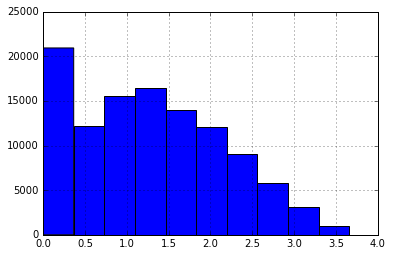

In [130]:
df_fixed['duration_days_log'] = df_fixed['duration_days'].map(lambda x: np.log10(x + 1))
df_fixed['duration_days_log'].hist()

Train test split

In [133]:
X_all = df_fixed['desc_init']
#X_all = df['short_desc_init']
y_all = df_fixed['duration_days_log']

X, X_test, y, y_test = train_test_split(X_all, y_all, test_size=0.25, random_state=42)

Class imbalance

In [134]:
print 'Majority is {}% cases in train'.format(y.value_counts().max() * 100 / y.value_counts().sum())
print 'Majority is {}% cases in test'.format(y_test.value_counts().max() * 100 / y_test.value_counts().sum())

Majority is 12.2895154164% cases in train
Majority is 12.4273678094% cases in test


Vectorize stuff

In [136]:
tfidf = vectorizer.transform(X)
print tfidf.shape
tfidf_test = vectorizer.transform(X_test)
print tfidf_test.shape

(82607, 22466)
(27536, 22466)


### Multinomial NB - desc_init

In [96]:
nb_model = MultinomialNB()

In [97]:
nb_model.fit(tfidf, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [98]:
y_pred = nb_model.predict(tfidf_test)

print 'accuracy: {}'.format(sklearn.metrics.accuracy_score(y_test, y_pred))
print 'precision: {}'.format(sklearn.metrics.precision_score(y_test, y_pred))
print 'recall: {}'.format(sklearn.metrics.recall_score(y_test, y_pred))
print ''
print 'confusion matrix: \n {}'.format(sklearn.metrics.confusion_matrix(y_test, y_pred))

accuracy: 0.295177222545
precision: 0.267809211621
recall: 0.295177222545



/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

confusion matrix: 
 [[2665   53  671  154 2028]
 [1214   75  547  165 2965]
 [1936   80  823  183 2408]
 [1474   68  632  207 2732]
 [1352   70  535  141 4358]]


### Random Forest - desc_init

In [124]:
rf_model = RandomForestClassifier(n_estimators=20, criterion='gini', 
                               max_depth=3, max_features='auto', 
                               bootstrap=True, oob_score=True,
                               random_state=None, warm_start=False)

In [125]:
rf_model.fit(tfidf,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [126]:
y_pred = rf_model.predict(tfidf_test)

print 'feature importances: {}'.format(rf_model.feature_importances_)
print 'oob score: {}'.format(rf_model.oob_score_)
print ''
print 'accuracy: {}'.format(sklearn.metrics.accuracy_score(y_test, y_pred))
print 'precision: {}'.format(sklearn.metrics.precision_score(y_test, y_pred))
print 'recall: {}'.format(sklearn.metrics.recall_score(y_test, y_pred))
print ''
print 'confusion matrix: \n {}'.format(sklearn.metrics.confusion_matrix(y_test, y_pred))

feature importances: [ 0.  0.  0. ...,  0.  0.  0.]
oob score: 0.252254651543

accuracy: 0.251670540383
precision: 0.170135880347


/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

recall: 0.251670540383

confusion matrix: 
 [[ 742    0    8    3 4818]
 [ 258    0    2    1 4705]
 [ 474    1    2    0 4953]
 [ 323    0    7    1 4782]
 [ 259    0   10    2 6185]]


### Gradient Boost - desc_init

In [103]:
gb_model = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                                   n_estimators=100, subsample=1.0,
                                   max_depth=3, init=None, 
                                   random_state=None, max_features=None, 
                                   verbose=0, max_leaf_nodes=None, warm_start=False)

In [104]:
gb_model.fit(tfidf,y)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [109]:
y_pred = gb_model.predict(tfidf_test.toarray())

print 'feature importances: {}'.format(gb_model.feature_importances_)
print ''
print 'accuracy: {}'.format(sklearn.metrics.accuracy_score(y_test, y_pred))
print 'precision: {}'.format(sklearn.metrics.precision_score(y_test, y_pred))
print 'recall: {}'.format(sklearn.metrics.recall_score(y_test, y_pred))
print ''
print 'confusion matrix: \n {}'.format(sklearn.metrics.confusion_matrix(y_test, y_pred))

feature importances: [ 0.0001677  0.         0.        ...,  0.         0.         0.       ]

accuracy: 0.289221382917
precision: 0.2719571918


/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

recall: 0.289221382917

confusion matrix: 
 [[1957   41  811   78 2684]
 [ 769   76  602  101 3418]
 [1300   64  943  130 2993]
 [ 935   65  731  131 3251]
 [ 814   90  607   88 4857]]


### Random Forest - desc_init regressor

In [132]:
rf1_model = RandomForestRegressor(n_estimators=20, criterion='mse', 
                               max_depth=3, max_features='auto', 
                               bootstrap=True, oob_score=True,
                               random_state=None, warm_start=False)

In [137]:
rf1_model.fit(tfidf, y)

/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [139]:
print 'feature importances: {}'.format(rf1_model.feature_importances_)
print 'oob score: {}'.format(rf1_model.oob_score_)
print 'r-squared: {}'.format(rf1_model.score(tfidf_test,y_test))

feature importances: [ 0.  0.  0. ...,  0.  0.  0.]
oob score: 0.0390567043731
r-squared: 0.0356680001073


(array([  4.50890000e+04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.81700000e+03,   0.00000000e+00,
          2.15000000e+03,   0.00000000e+00,   1.41400000e+03,
          1.08900000e+03,   9.72000000e+02,   8.71000000e+02,
          7.06000000e+02,   1.04900000e+03,   8.62000000e+02,
          7.87000000e+02,   9.88000000e+02,   8.40000000e+02,
          8.15000000e+02,   1.10700000e+03,   9.14000000e+02,
          9.83000000e+02,   9.42000000e+02,   9.32000000e+02,
          9.83000000e+02,   1.02500000e+03,   9.64000000e+02,
          1.05000000e+03,   1.01500000e+03,   1.02400000e+03,
          8.65000000e+02,   8.92000000e+02,   9.27000000e+02,
          9.06000000e+02,   9.17000000e+02,   8.28000000e+02,
          7.77000000e+02,   7.16000000e+02,   6.46000000e+02,
          6.09000000e+02,   5.22000000e+02,   4.40000000e+02,
          3.63000000e+02,   3.05000000e+02,   2.13000000e+02,
          1.72000000e+02,   1.30000000e+02,   7.40000000e+01,
        

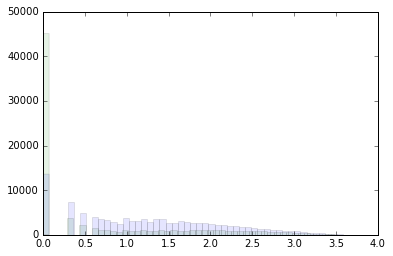

In [61]:
%matplotlib inline
plt.hist(np.log10(df[df.resolution_final=='fixed']['duration_days'].values + 1), bins=50, alpha=0.1)
plt.hist(np.log10(df[df.resolution_final=='duplicate']['duration_days'].values + 1), bins=50, alpha=0.1)

In [58]:
pd.crosstab(df['resolution_final'], df['resolution_init'])

resolution_init,,duplicate,fixed,invalid,later,wontfix,worksforme
resolution_final,,,,,,,
,4,0,0,0,0,0,0
duplicate,82764,3,2,0,1,0,0
expired,4593,0,0,0,0,0,0
fixed,110036,0,107,0,0,0,0
incomplete,21548,0,0,0,0,0,0
invalid,34217,0,0,2,0,0,0
moved,14,0,0,0,0,0,0
wontfix,9838,0,0,0,0,5,0
worksforme,47810,0,0,1,0,0,2
